In [161]:
# imports
import genData
import importlib
importlib.reload(module=genData)

import torch
from torch.utils.data import DataLoader
from torch import nn

%matplotlib ipympl
import matplotlib.pyplot as plt

In [165]:
# first is function that generates the data, second is number of dimensions
InputShape = {
    'CIRCLESINCIRCLE': (genData.spheresInSphere2D, 2),
    'INTERLOCKING_TORI': (genData.interlockingTori, 3),
    'SPHERELAYERS': (genData.spheresInSpheresInSpheres3D, 3)
    }

### Start Here
Interact with the program by selecting your input shape from the three options above, changing your NN_SHAPE, and then running all. See your graphs at the bottom.

In [171]:
# variables

# choose input shape
INPUT_SHAPE = InputShape['CIRCLESINCIRCLE']

# choose neural network hyperparameters
NN_SHAPE = [30] * 10 # list of number of dimensions in each hidden layer
BATCH_SIZE = 50 # for stochastic gradient descent
EPOCHS = 20 # training epochs, can easily change later to make it go until loss is negligible

# choose size of training and testing data
TRAIN_POINTS = 10000
TEST_POINTS = 5000


In [172]:
D = INPUT_SHAPE[1]

# train and test datasets
# train_pts = torch.tensor(, dtype=torch.float)
# test_pts = torch.tensor(, dtype=torch.float)
train = genData.TopologicalDataset(INPUT_SHAPE[0](TRAIN_POINTS, 10))
test = genData.TopologicalDataset(INPUT_SHAPE[0](TEST_POINTS, 10))

# dataloader
loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [174]:
# nueral network class
class Classifier(nn.Module):

    def __init__(self, layers): # where layers has the number of dimensions of each layer at each index, the first being the dimensions of the input
        super().__init__()
        # build a list with all the functions data passes through in order
        # note that layers are actually functions
        self.seqlist = nn.ParameterList()
        for l in range(len(layers)-1):
            self.seqlist.append(nn.Linear(layers[l], layers[l+1]))
            self.seqlist.append(nn.ReLU())
        self.seqlist.append(nn.Linear(layers[len(layers)-1], 1)) # output
        self.seqlist.append(nn.Sigmoid())
        self.numlayers = len(layers) # including input but not output

    def forward(self, x):
        for function in self.seqlist:
            x = function(x)
        return x.reshape(len(x))

    # where x is the data and y is the known labels
    def plot(self, x, y):

        colormap = ['blue','red']
        colors = [colormap[i] for i in y.type(torch.int)]

        for l in range(0, len(self.seqlist), 2):
            data = x.detach() # makes data usable by taking of gradient
            x = self.seqlist[l+1](self.seqlist[l](x))
            n = int(l/2)

            # pca without really understanding it :(
            #print(torch.pca_lowrank(data)[2][:, :3])
            print((torch.pca_lowrank(data)[1] ** 2)/(data.size()[0]-1))
            data = torch.matmul(data, torch.pca_lowrank(data)[2][:, :3])

            if data.size()[1] == 3:
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(data[:,0], data[:,1], data[:,2], s=12, c=colors)
                ax.view_init(elev=0, azim=-35, roll=0)

            elif data.size()[1] == 2:
                ax = plt.figure().add_subplot(projection=None)
                ax.scatter(data[:,0], data[:,1], s=12, c=colors)

            ax.axis("equal")
            ax.set_title('layer #' + str(n))

        plt.show()

        return nn.Sigmoid()(x).reshape(len(x))


In [177]:
# training neural network

net = Classifier([D] + NN_SHAPE)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.BCELoss() # binary cross-entropy

for epoch in range(EPOCHS):
    net.train() # just puts it in training mode
    for batch in loader:
        x, y = batch
        y = y.type(torch.float32)
        net.zero_grad()
        output = net(x)
        loss = loss_function(output, y) 
        loss.backward() # magic
        optimizer.step() # adjusts weights
    print(loss)


tensor(0.3650, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1104, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3286, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1006, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0685, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0204, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0937, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0047, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0276, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0077, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1490, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0184, grad_fn=<Bina

In [178]:
# evaluate the network

net.eval()
correct = 0
total = 0

with torch.no_grad(): # tells pytorch your not calculating gradients so reduces memory consumption
    for data in test_loader:
        x, y = data
        output = net(x)
        for idx, i in enumerate(output): # enumerate lets you go over something by index and by actual object
            if torch.round(i, decimals=0) == y[idx]: # torch.argmax returns the index of the max value in the tensor
                correct += 1
            total += 1

print('Accuracy: ', round(correct/total, 3))


Accuracy:  0.988


tensor([0.2500, 0.2403])
tensor([0.7733, 0.7297, 0.0634, 0.0377, 0.0093, 0.0044])
tensor([0.2502, 0.2097, 0.0827, 0.0326, 0.0118, 0.0049])
tensor([0.2864, 0.0773, 0.0535, 0.0105, 0.0044, 0.0022])
tensor([0.5238, 0.0337, 0.0117, 0.0054, 0.0025, 0.0010])
tensor([1.0323e+00, 3.3827e-02, 2.4777e-02, 1.5803e-03, 5.7533e-04, 2.2601e-04])
tensor([3.8681e+00, 1.2541e-01, 4.3079e-02, 1.4671e-03, 5.2135e-04, 2.9671e-04])
tensor([9.1298e+00, 2.9085e-01, 1.3907e-01, 1.5293e-02, 3.9910e-03, 1.8872e-03])
tensor([2.5092e+01, 9.7224e-01, 2.9132e-01, 6.8919e-02, 1.3422e-02, 4.9363e-03])
tensor([6.8831e+01, 3.3773e+00, 3.9086e-01, 1.6622e-01, 2.0043e-02, 5.9583e-03])
tensor([1.0292e+02, 1.3986e+01, 8.7432e-01, 5.1003e-01, 2.3459e-02, 5.6156e-03])


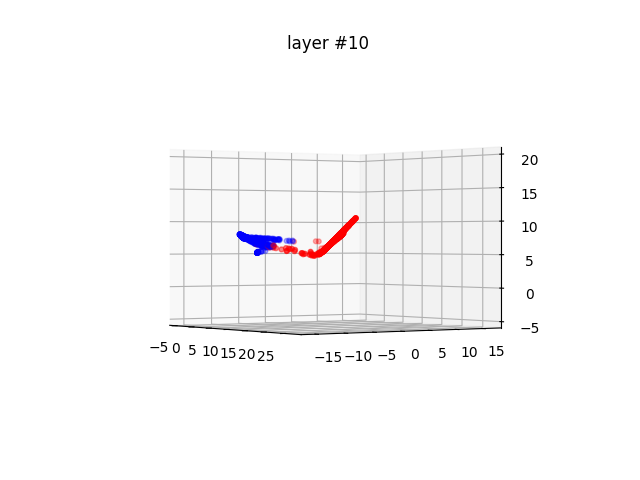

tensor([0.5268, 0.5049, 0.7311, 0.7310, 0.5027, 0.7310, 0.5732, 0.5001, 0.5058,
        0.7307, 0.7310, 0.5002, 0.7310, 0.5001, 0.7310, 0.7310, 0.5001, 0.5001,
        0.7280, 0.7310, 0.7310, 0.5001, 0.5001, 0.7311, 0.5001, 0.5002, 0.7311,
        0.7311, 0.5026, 0.5001, 0.5005, 0.7311, 0.7310, 0.7311, 0.5110, 0.7310,
        0.7311, 0.5006, 0.7311, 0.5005, 0.7310, 0.7310, 0.5001, 0.5047, 0.5011,
        0.5001, 0.5001, 0.5247, 0.5004, 0.5083, 0.5001, 0.7311, 0.7311, 0.5001,
        0.5001, 0.7311, 0.5027, 0.5122, 0.5015, 0.7310, 0.6789, 0.7310, 0.5001,
        0.5009, 0.5001, 0.5001, 0.7310, 0.7310, 0.5002, 0.7308, 0.5010, 0.5005,
        0.5004, 0.7311, 0.7310, 0.7310, 0.7311, 0.7310, 0.7309, 0.5001, 0.5001,
        0.7292, 0.7310, 0.7311, 0.5004, 0.5001, 0.7310, 0.7310, 0.7310, 0.7310,
        0.5001, 0.5001, 0.5002, 0.5138, 0.7310, 0.5076, 0.7310, 0.5010, 0.7311,
        0.5001, 0.5339, 0.7311, 0.5002, 0.7311, 0.7305, 0.7311, 0.7311, 0.5188,
        0.5132, 0.5001, 0.7311, 0.7310, 

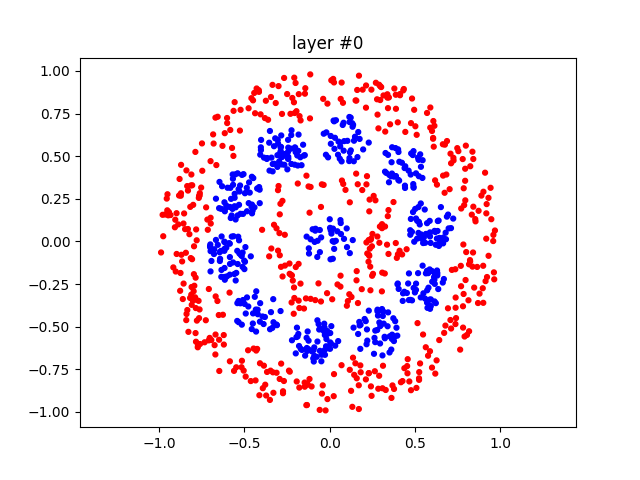

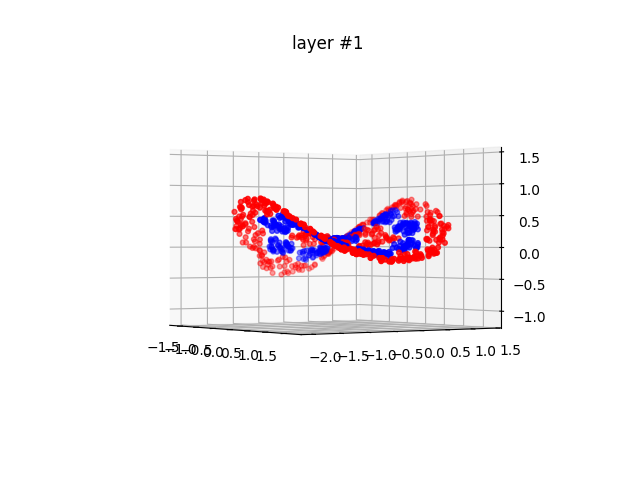

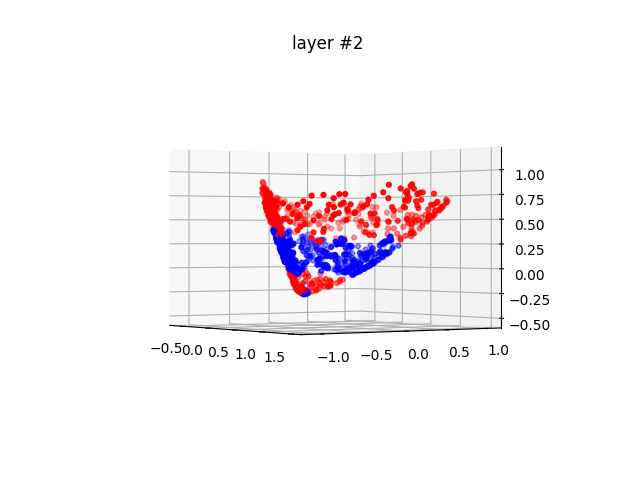

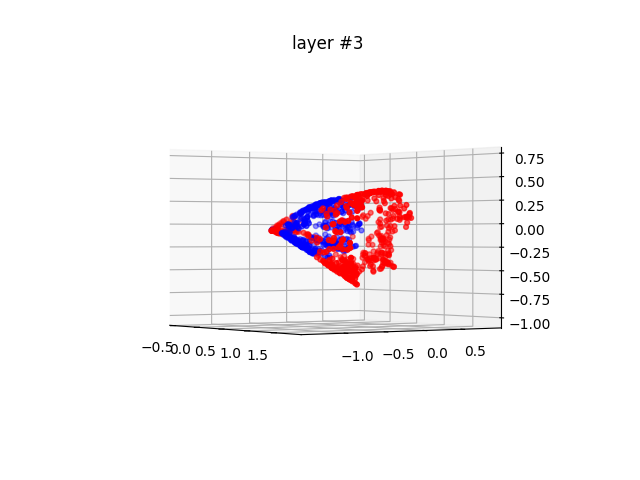

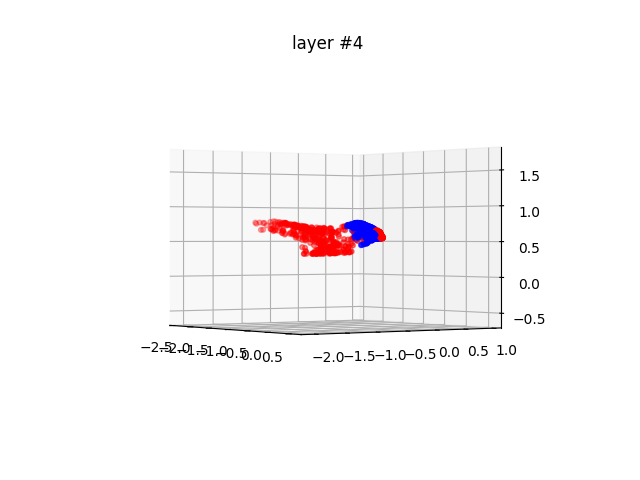

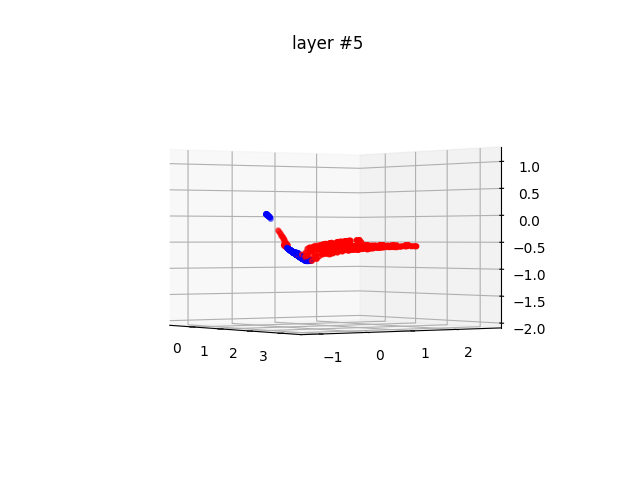

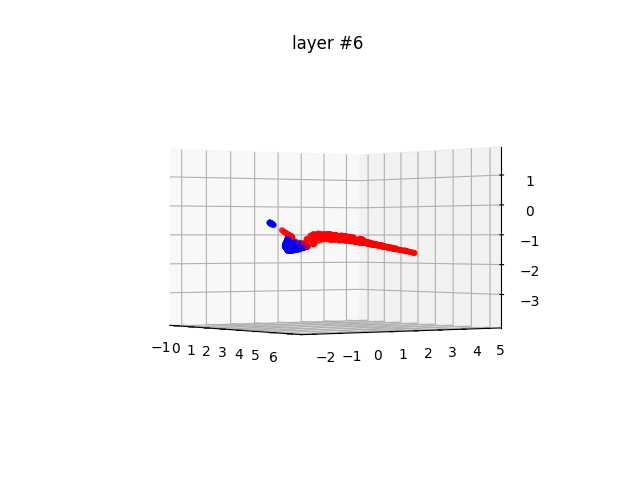

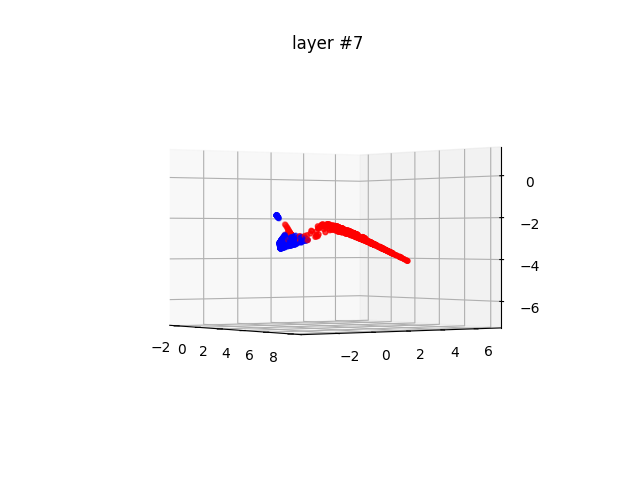

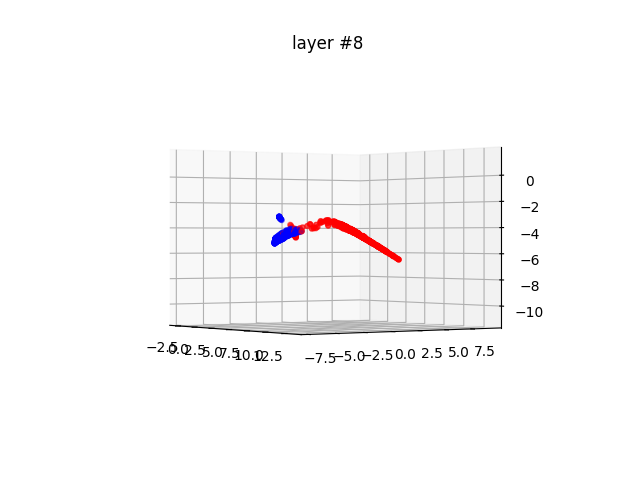

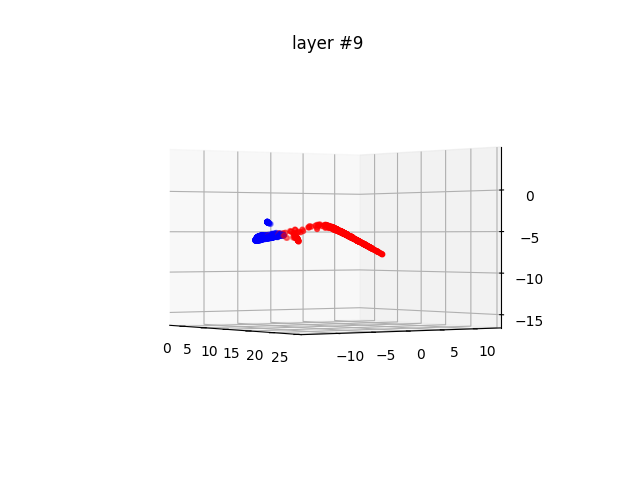

In [179]:
# see evolution of the topology
visualizationLoader = DataLoader(test, batch_size=1000, shuffle=True)
data = next(iter(visualizationLoader))
x, y = data
net.plot(x, y)